<a href="https://colab.research.google.com/github/IamRabin/NLP/blob/master/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toxic Comment Classification
This file contains the code for the project carried out on toxic comment classfication, detail report has been attached along with this file.




In [ ]:
! unzip "/content/drive/My Drive/jigsaw-toxic-comment-classification-challenge.zip"

Archive:  /content/drive/My Drive/jigsaw-toxic-comment-classification-challenge.zip
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [ ]:
! unzip "/content/train.csv.zip"

Archive:  /content/train.csv.zip
  inflating: train.csv               


In [ ]:
! unzip "/content/test.csv.zip"

Archive:  /content/test.csv.zip
  inflating: test.csv                


# Required packages


In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from collections import defaultdict
import re

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import Callback


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# Load Dataset



In [2]:
train=pd.read_csv("/content/train.csv")
test=pd.read_csv("/content/test.csv")
y_labels=pd.read_csv("/content/drive/My Drive/test_labels.csv")


In [3]:
test= pd.concat([test,y_labels], axis=1)

In [4]:

test=test[ (test.iloc[:,3:].apply(lambda x:x >=0)).any(axis=1) ]


   

In [5]:
EMBEDDING_FILE="/content/drive/My Drive/glove.6B.50d.txt"

# Data Exploration


In [ ]:
train[10:15]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
10,0005300084f90edc,"""\nFair use rationale for Image:Wonju.jpg\n\nT...",0,0,0,0,0,0,True
11,00054a5e18b50dd4,bbq \n\nbe a man and lets discuss it-maybe ove...,0,0,0,0,0,0,True
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,False
13,0006f16e4e9f292e,Before you start throwing accusations and warn...,0,0,0,0,0,0,True
14,00070ef96486d6f9,"Oh, and the girl above started her arguments w...",0,0,0,0,0,0,True


In [ ]:
print("Training entries: {}".format(len(train)))

Training entries: 159571


In [ ]:
x=train.iloc[:,2:].sum()
#clean comments
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
#count number of clean entries
train['clean'].sum()
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  143346
Total tags = 35098


In [ ]:
#checking NA
null_check=train.isnull().sum()
print(null_check)

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64


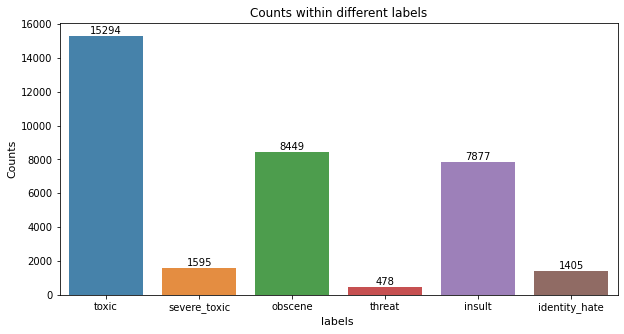

In [6]:
x=train.iloc[:,2:].sum()
#plotting
plt.figure(figsize=(10,5))
ax= sns.barplot(x.index, x.values, alpha=0.9)
plt.title("Counts within different labels")
plt.ylabel('Counts', fontsize=11)
plt.xlabel('labels ', fontsize=11)
#adding text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

**Observing the correaltion between the labels.**

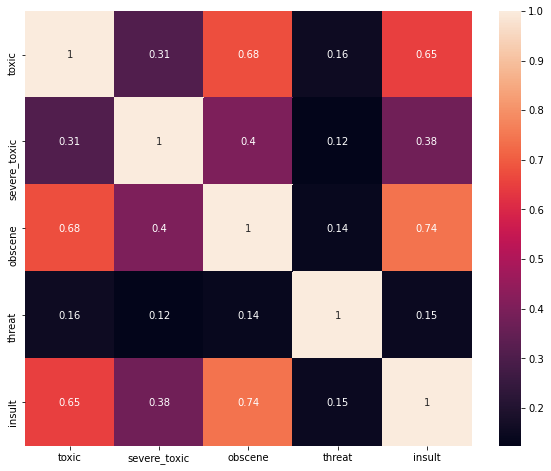

In [7]:
corr=train.iloc[:,:-1].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

# Preprocessing text

We will make the letters lower case and applying regex we can remove some of the postfix and special tokens.




In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
STOPWORDS = nltk.corpus.stopwords.words('english')
len(STOPWORDS)

179

In [10]:


# for removing  Non-Alpha Numeric and space

special_character=re.compile(r'[^a-z\d ]',re.IGNORECASE)

# for replacing numerics
replace_numbers=re.compile(r'\d+',re.IGNORECASE)


def clean(text, stem_words=False):
   
    text = text.lower()
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"i’m", "i am", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = replace_numbers.sub('', text)
    text = special_character.sub('',text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text





In [11]:
train_comments = []
test_comments = []

sents_train = train["comment_text"].values
classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
train_labels = train[classes].values

sents_test = test["comment_text"].values
test_label = (test[classes].values) 

train_comments = [clean(text) for text in sents_train]
test_comments = [clean(text) for text in sents_test]


In [ ]:
for i in range(3):
    print("Cleaned\n", train_comments[i] + '\n')
    print("Original\n", train.iloc[i]['comment_text'] + '\n')
    print("------------------")

Cleaned
 explanation edits made username hardcore metallica fan reverted vandalisms closure gas voted new york dolls fac please remove template talk page since retired

Original
 Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

------------------
Cleaned
 aww matches background colour seemingly stuck thanks talk january utc

Original
 D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)

------------------
Cleaned
 hey man really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info

Original
 Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead

#Embedding

In [12]:
embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

In [13]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_comments))
tokenized_train = tokenizer.texts_to_sequences(train_comments)
tokenized_test = tokenizer.texts_to_sequences(test_comments)
X_train = pad_sequences(tokenized_train, maxlen=maxlen)
X_test = pad_sequences(tokenized_test, maxlen=maxlen)


In [14]:
def get_coefs(word,*arr): 
  return word, np.asarray(arr, dtype='float32')
  
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

In [15]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


(0.020940498, 0.6441043)

In [16]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

#Model Building and Evaluation

First we start with the baseline model of unidirectional LSTM.

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X_train,train_labels, random_state=112)

In [18]:
#LSTM takes in a tensor of [Batch Size, Time Steps, Number of Inputs]
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(6, activation="sigmoid")(x)
uni_model = Model(inputs=inp, outputs=x)
uni_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [19]:
uni_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 50)           1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 100, 50)           20200     
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                2550      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306   

In [20]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history=uni_model.fit(x_train, y_train, batch_size=40, epochs=2, 
                  validation_data=(x_val, y_val),callbacks=[callback]);

Epoch 1/2
2992/2992 [==============================] - 447s 149ms/step - loss: 0.0747 - accuracy: 0.8782 - val_loss: 0.0548 - val_accuracy: 0.9941
Epoch 2/2
2992/2992 [==============================] - 456s 152ms/step - loss: 0.0516 - accuracy: 0.9907 - val_loss: 0.0509 - val_accuracy: 0.9941


In [21]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')

plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [60]:
model.save('/content/tc_model.h5')

In [22]:
y_score=uni_model.predict(X_test,batch_size=1024,verbose=1)


63/63 [==============================] - 14s 218ms/step


In [23]:
results = uni_model.evaluate(X_test, test_label)
print(results)

2000/2000 [==============================] - 33s 17ms/step - loss: 0.0715 - accuracy: 0.9976
[0.07150215655565262, 0.9976085424423218]


Plotting ROC Curve:

In [25]:
from itertools import cycle
from scipy import interp
from sklearn.metrics import roc_curve,precision_recall_curve, auc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


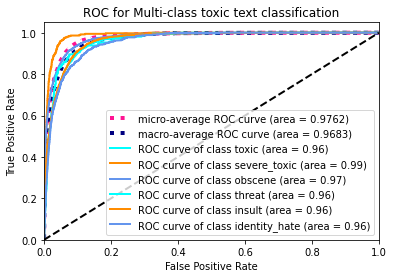

In [26]:
 
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(train_labels.shape[1]):
    fpr[i], tpr[i], _ = roc_curve( test_label[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_label.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(train_labels.shape[1])]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(train_labels.shape[1]):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i]) 

# Finally average it and compute AUC
mean_tpr /= train_labels.shape[1]

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(train_labels.shape[1]), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Multi-class toxic text classification')
plt.legend(loc="lower right")
plt.show()

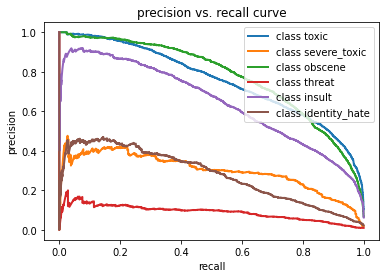

In [65]:
# precision recall curve
precision = dict()
recall = dict()
for i in range(train_labels.shape[1]):
    precision[i], recall[i], _ = precision_recall_curve(test_label[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(classes[i]))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="upper right")
plt.title("precision vs. recall curve")
plt.show()

#Applying Attention

In [35]:
class Attention(tf.keras.Model):

	def __init__(self, units):
		super(Attention, self).__init__()
		self.W1 = tf.keras.layers.Dense(units)
		self.W2 = tf.keras.layers.Dense(units)
		self.V = tf.keras.layers.Dense(1)

	def call(self, features, hidden):
		# hidden shape == (batch_size, hidden size)
		# hidden_with_time_axis shape == (batch_size, 1, hidden size)
		# we are doing this to perform addition to calculate the score
		hidden_with_time_axis = tf.expand_dims(hidden, 1)
		  
		# score shape == (batch_size, max_length, 1)
		# we get 1 at the last axis because we are applying score to self.V
		# the shape of the tensor before applying self.V is (batch_size, max_length, units)
		score = tf.nn.tanh(
			self.W1(features) + self.W2(hidden_with_time_axis))
		# attention_weights shape == (batch_size, max_length, 1)
		attention_weights = tf.nn.softmax(self.V(score), axis=1)
		  
		# context_vector shape after sum == (batch_size, hidden_size)
		context_vector = attention_weights * features
		context_vector = tf.reduce_sum(context_vector, axis=1)
		return context_vector, attention_weights

In [54]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
lstm = Bidirectional(LSTM(50, return_sequences=True), name="bi_lstm_0")(x)

(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(50,return_state=True,
                                                                          return_sequences=True),
                                                                          name="bi_lstm_1")(lstm)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
context_vector, attention_weights = Attention(10)(lstm, state_h)

dense1 = Dense(20, activation="relu")(context_vector)

output = Dense(6, activation="sigmoid")(dense1)
  
model = keras.Model(inputs=inp, outputs=output)

model.summary()



Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 100, 50)      1000000     input_5[0][0]                    
__________________________________________________________________________________________________
bi_lstm_0 (Bidirectional)       (None, 100, 100)     40400       embedding_4[0][0]                
__________________________________________________________________________________________________
bi_lstm_1 (Bidirectional)       [(None, 100, 100), ( 60400       bi_lstm_0[0][0]                  
____________________________________________________________________________________________

In [55]:
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [56]:

history=model.fit(x_train, y_train,validation_data=(x_val, y_val), batch_size=40, epochs=2);

      

Epoch 1/2
2992/2992 [==============================] - 701s 234ms/step - loss: 0.0662 - accuracy: 0.9770 - val_loss: 0.0526 - val_accuracy: 0.9941
Epoch 2/2
2992/2992 [==============================] - 703s 235ms/step - loss: 0.0462 - accuracy: 0.9938 - val_loss: 0.0490 - val_accuracy: 0.9931


In [57]:
y_score=model.predict(X_test,batch_size=1024,verbose=1)


63/63 [==============================] - 61s 969ms/step


In [59]:
results = model.evaluate(X_test, test_label)
print(results)

2000/2000 [==============================] - 97s 48ms/step - loss: 0.0760 - accuracy: 0.9931
[0.07597152143716812, 0.99310702085495]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


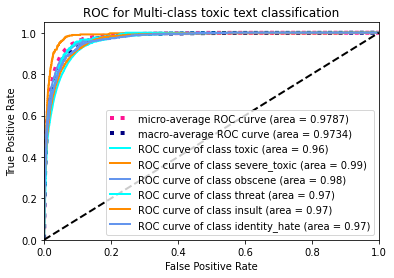

In [58]:
 
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(train_labels.shape[1]):
    fpr[i], tpr[i], _ = roc_curve( test_label[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_label.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(train_labels.shape[1])]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(train_labels.shape[1]):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i]) 

# Finally average it and compute AUC
mean_tpr /= train_labels.shape[1]

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(train_labels.shape[1]), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Multi-class toxic text classification')
plt.legend(loc="lower right")
plt.show()

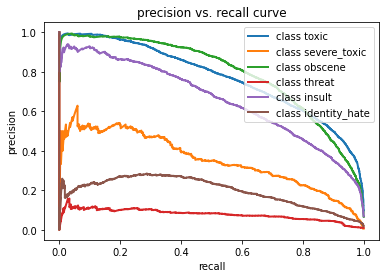

In [43]:
# precision recall curve
precision = dict()
recall = dict()
for i in range(train_labels.shape[1]):
    precision[i], recall[i], _ = precision_recall_curve(test_label[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(classes[i]))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="upper right")
plt.title("precision vs. recall curve")
plt.show()